In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

np.random.seed(42)
torch.manual_seed(42)
device = "cpu"

In [25]:
# Data
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

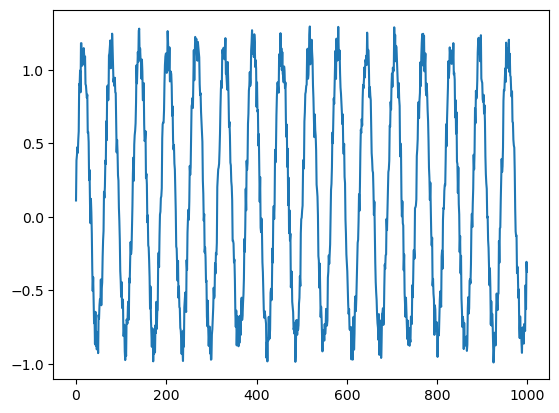

In [26]:
data = np.sin(np.linspace(0,100,1000)) + np.random.rand(1000)*0.3 # start / end / number
plt.plot(data)

In [27]:
# Sliding window process to generate X (inputs) and y(outpus) 

i = 0
L = 10
X = []
y = []
for i in range(1000 - L):
    X.append(data[i: i+L])
    y.append(data[i+L])

X = np.array(X).reshape(-1, L, 1)
y = np.array(y)
X.shape, y.shape


((990, 10, 1), (990,))

In [28]:
X_train = X[:800]
y_train = y[:800]
X_test = X[800:]
y_test = y[800:]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((800, 10, 1), (800,), (190, 10, 1), (190,))

In [29]:
# Dataset

In [30]:
from torch.utils.data import Dataset

class MyDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.from_numpy(data).float()
        self.labels = torch.from_numpy(labels).float()
        
    def __getitem__(self, index):
        return (self.data[index], self.labels[index])

    def __len__(self):
        return len(self.data)
    
train_dataset = MyDataset(X_train, y_train)
print(train_dataset[0])

(tensor([[0.1124],
        [0.3851],
        [0.4185],
        [0.4754],
        [0.4366],
        [0.5267],
        [0.5826],
        [0.9046],
        [0.8982],
        [0.9963]]), tensor(0.8482))


In [31]:
# Train/Val split

In [32]:
from torch.utils.data.dataset import random_split

train_dataset, val_dataset = random_split(train_dataset, [600, 200])

len(train_dataset), len(val_dataset) # after train/val split



(600, 200)

In [33]:
#Dataloader

In [34]:
from torch.utils.data import DataLoader

train_loader = DataLoader(dataset=train_dataset, batch_size=16)
val_loader = DataLoader(dataset=val_dataset, batch_size=4)
len(train_loader), len(val_loader)

(38, 50)

In [35]:
#Model

In [36]:
# class MyModel(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.rnn = nn.RNN(input_size=1, hidden_size=32, batch_first=True) # batch_first = True -> 16 * 10 * 1 (b * L * d)
#         self.fc= nn.Linear(32, 1)
        
#     def forward(self, x):
#         outs, hidden = self.rnn(x)
#         out = outs[:,-1,:]
        
#         out = self.fc(out)
#         return out
    
# tmpModel = MyModel()
# tmpBatch, _ = next(iter(train_loader))
# tmpOut = tmpModel(tmpBatch)
# tmpOut.shape

In [37]:
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.RNN(input_size=1, hidden_size=32, batch_first=True)
        self.fc = nn.Linear(32,1)

    
    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), 32)
        outs, hidden = self.rnn(x)
        out = outs[:,-1,:]

        out  = self.fc(out)
        return out
    
tmpModel = MyModel()
tmpBatch,_ = next(iter(train_loader))
tmpOut = tmpModel(tmpBatch)
tmpOut.shape

torch.Size([16, 1])

In [38]:
# Model training

model = MyModel().to(device)

print(model.state_dict())

train_losses = [] # To track the training loss
validation_losses = [] # To track the validation loss

lr = 1e-1
n_epochs = 10

loss_fn = nn.MSELoss(reduction='mean')
optimizer = optim.SGD(model.parameters(), lr=lr)

for epoch in range(n_epochs):
    # Training Loop
    model.train() 
    train_loss = 0
    
    for x_batch, y_batch in train_loader: # The mini batches loop for train
            
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        
        yhat = model(x_batch)
        loss = loss_fn(yhat, y_batch)
        
        train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()    
        optimizer.step()
        
    train_loss /= len(train_loader)
    train_losses.append(train_loss) # keep tracking of the losses
    
    # Validation Loop
    model.eval()
    validation_loss = 0
    
    with torch.no_grad():
        for x_val, y_val in val_loader: # The mini batches loop for validation

            x_val = x_val.to(device)
            y_val = y_val.to(device)

            yhat = model(x_val)
            val_loss = loss_fn(y_val, yhat)
            
            validation_loss += val_loss.item()
    
    validation_loss /= len(val_loader)
    validation_losses.append(validation_loss) # keep tracking of the losses
    
print(model.state_dict())

OrderedDict([('rnn.weight_ih_l0', tensor([[-0.1184],
        [ 0.0638],
        [-0.1521],
        [ 0.0143],
        [ 0.1032],
        [ 0.0340],
        [ 0.0235],
        [ 0.0259],
        [-0.0518],
        [-0.0337],
        [-0.0745],
        [-0.1194],
        [-0.0936],
        [ 0.1748],
        [-0.0296],
        [ 0.0619],
        [ 0.1223],
        [-0.0138],
        [-0.0951],
        [-0.1198],
        [-0.0651],
        [ 0.0631],
        [-0.1489],
        [-0.0216],
        [ 0.0672],
        [ 0.1442],
        [ 0.0532],
        [ 0.0350],
        [ 0.1210],
        [ 0.0817],
        [ 0.0598],
        [-0.0548]])), ('rnn.weight_hh_l0', tensor([[-0.1418, -0.0382, -0.0321,  ..., -0.1670,  0.1467, -0.0845],
        [-0.0733,  0.0163,  0.0458,  ...,  0.1666,  0.0821,  0.0380],
        [-0.0358,  0.0836,  0.0647,  ...,  0.1125, -0.1380,  0.1169],
        ...,
        [-0.1105,  0.0905, -0.1015,  ...,  0.1528,  0.1414,  0.0110],
        [-0.0142,  0.1375,  0.0780,  ...,

/Users/fulin/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/fulin/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/fulin/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same 

OrderedDict([('rnn.weight_ih_l0', tensor([[-0.1126],
        [ 0.0599],
        [-0.1403],
        [ 0.0101],
        [ 0.0922],
        [ 0.0300],
        [ 0.0120],
        [ 0.0253],
        [-0.0568],
        [-0.0506],
        [-0.0761],
        [-0.1135],
        [-0.0900],
        [ 0.1884],
        [-0.0306],
        [ 0.0746],
        [ 0.1354],
        [-0.0245],
        [-0.0904],
        [-0.1158],
        [-0.0578],
        [ 0.0620],
        [-0.1527],
        [-0.0006],
        [ 0.0566],
        [ 0.1603],
        [ 0.0562],
        [ 0.0313],
        [ 0.1015],
        [ 0.0698],
        [ 0.0636],
        [-0.0372]])), ('rnn.weight_hh_l0', tensor([[-0.1516, -0.0315, -0.0380,  ..., -0.1641,  0.1503, -0.0813],
        [-0.0631,  0.0070,  0.0548,  ...,  0.1605,  0.0783,  0.0386],
        [-0.0473,  0.0931,  0.0559,  ...,  0.1179, -0.1337,  0.1181],
        ...,
        [-0.1004,  0.0805, -0.0920,  ...,  0.1457,  0.1378,  0.0123],
        [-0.0154,  0.1403,  0.0752,  ...,

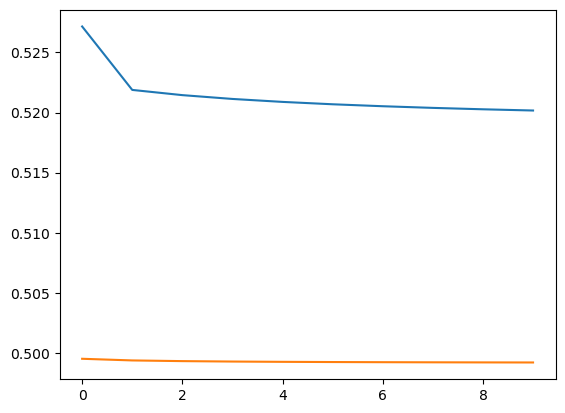

In [39]:
plt.plot(train_losses,label="train loss")
plt.plot(validation_losses, label="val loss")

In [40]:
y_pred = model( torch.from_numpy(X_test).float().to(device) )
y_pred = y_pred.detach().numpy()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


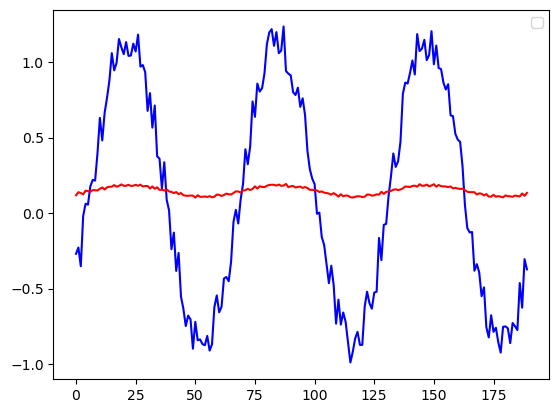

In [41]:
plt.plot(y_test,c='b')
plt.plot(y_pred,c='r')
plt.legend()

In [20]:
# Validation